<a href="https://colab.research.google.com/github/TheHouseOfVermeulens/Financial-Engineering/blob/master/Introduction_to_Pairs_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Useful Functions
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [0]:
# Useful Libraries
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

#Testing Artificial Examples

We'll use some artificially generated series first as they are much cleaner and easier to work with. In general when learning or developing a new technique, use simulated data to provide a clean environment. Simulated data also allows you to control the level of noise and difficulty level for your model.
a. Cointegration Test I

Determine whether the following two artificial series A
and B are cointegrated using the `coint()` function and a reasonable confidence level.

In [0]:
A_returns = np.random.normal(0, 1, 100)
A = pd.Series(np.cumsum(A_returns), name='X') + 50

some_noise = np.random.exponential(1, 100)
 
B = A - 7 + some_noise


In [0]:
score, pvalue, _ = coint(A,B)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("A and B are cointegrated")
    print pvalue
else:
    print ("A and B are not cointegrated")
    print pvalue
    
A.name = "A"
B.name = "B"
pd.concat([A, B], axis=1).plot();



```
A and B are cointegrated
6.96867595624e-15
```



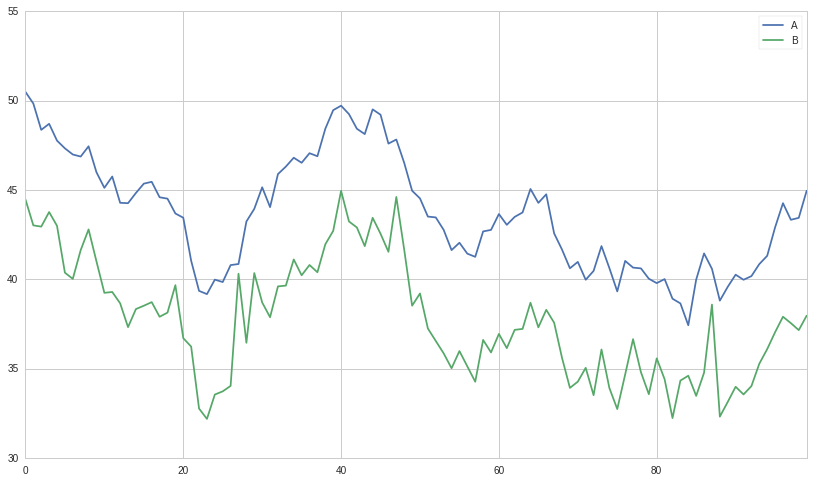

##b. Cointegration Test II

Determine whether the following two artificial series C
and D are cointegrated using the coint() function and a reasonable confidence level.

In [0]:
C_returns = np.random.normal(1, 1, 100) 
C = pd.Series(np.cumsum(C_returns), name='X') + 100

D_returns = np.random.normal(2, 1, 100)
D = pd.Series(np.cumsum(D_returns), name='X') + 100

In [0]:
score, pvalue, _ = coint(C,D)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("C and D are cointegrated")
    print pvalue
else:
    print ("C and D are not cointegrated")
    print pvalue

C.name = "C"
D.name = "D"
pd.concat([C, D], axis=1).plot();



```
C and D are not cointegrated
0.487261538359
```



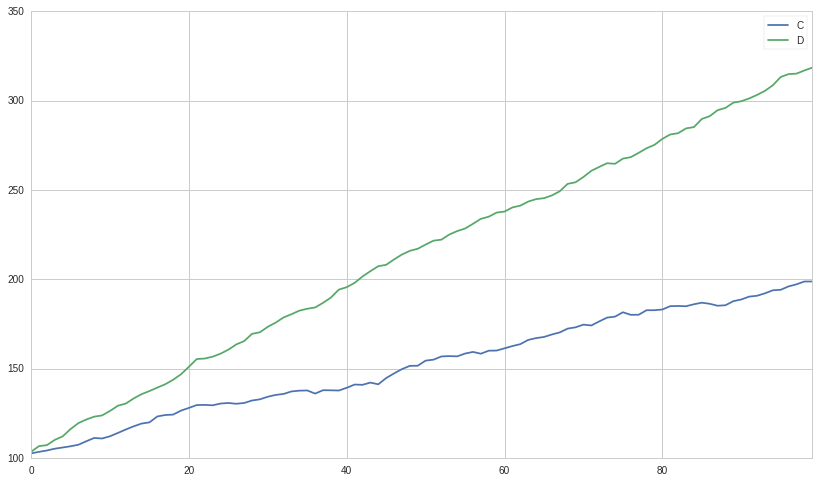

#Testing Real Examples
##a. Real Cointegration Test I

Determine whether the following two assets UAL and AAL were cointegrated during 2015 using the coint() function and a reasonable confidence level.

In [0]:
ual = get_pricing('UAL', fields=['price'], 
                        start_date='2015-01-01', end_date='2016-01-01')['price']
aal = get_pricing('AAL', fields=['price'], 
                        start_date='2015-01-01', end_date='2016-01-01')['price']


In [0]:
score, pvalue, _ = coint(ual, aal)

confidence_level = 0.05

if pvalue < confidence_level:
    print ("UAL and AAL are cointegrated")
    print pvalue
else:
    print ("UAL and AAL are not cointegrated")
    print pvalue

ual.name = "UAL"
aal.name = "AAL"
pd.concat([ual, aal], axis=1).plot();



```
UAL and AAL are not cointegrated
0.11339061615
```



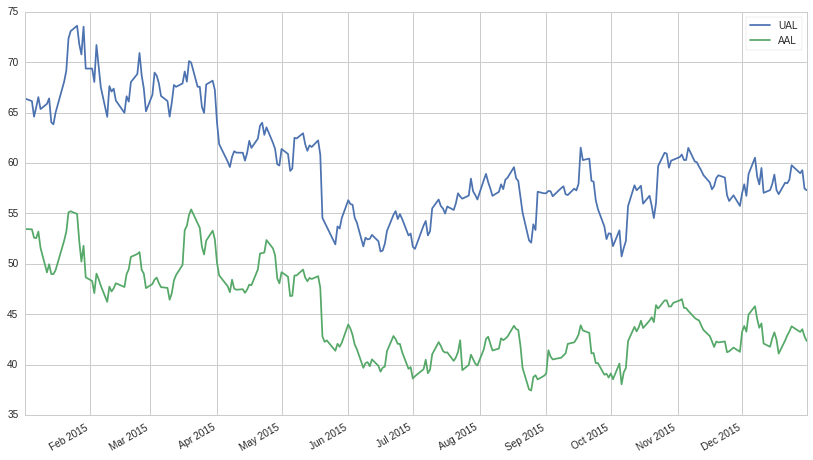


##b. Real Cointegration Test II

Determine whether the following two assets FCAU and HMC were cointegrated during 2015 using the coint() function and a reasonable confidence level.


In [0]:
fcau = get_pricing('FCAU', fields=['price'], 
                        start_date='2015-01-01', end_date='2016-01-01')['price']
hmc = get_pricing('HMC', fields=['price'], 
                        start_date='2015-01-01', end_date='2016-01-01')['price']

In [0]:
confidence_level = 0.05

score, pvalue, _ = coint(fcau, hmc)

if pvalue < confidence_level:
    print ("FCAU and HMC are cointegrated")
    print pvalue
else:
    print ("FCAU and HMC are not cointegrated")
    print pvalue

fcau.name = "FCAU"
hmc.name = "HMC"
pd.concat([fcau, hmc], axis=1).plot();





```
FCAU and HMC are cointegrated
0.013687770819
```





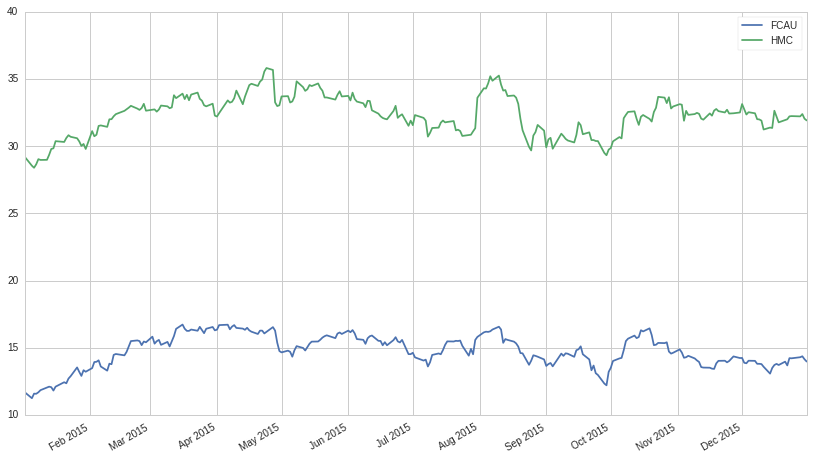

#Searching for Cointegrated Pairs

Use the find_cointegrated_pairs function, defined in the "Helper Functions" section above, to find any cointegrated pairs among a set of metal and mining securities.

In [0]:
symbol_list = ['MTRN', 'CMP', 'TRQ', 'SCCO', 'HCLP','SPY']
prices_df = get_pricing(symbol_list, fields=['price']
                               , start_date='2015-01-01', end_date='2016-01-01')['price']
prices_df.columns = map(lambda x: x.symbol, prices_df.columns)

In [0]:
scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.99)
                )
print pairs

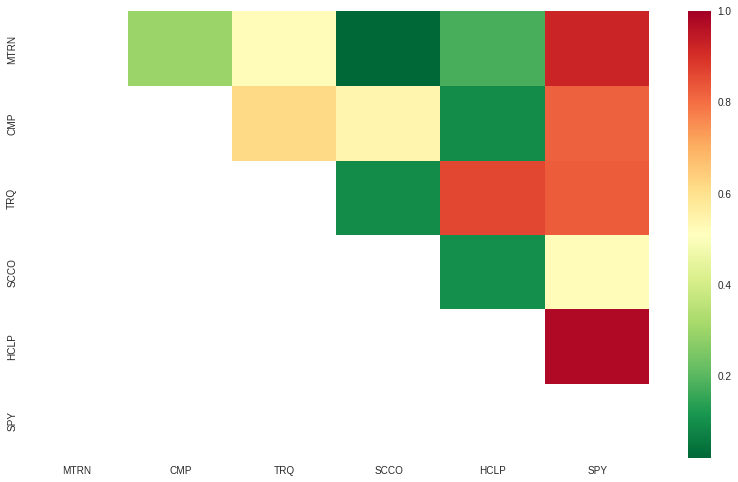

#Out of Sample Validation
##a. Calculating the Spread

Using pricing data from 2015, construct a linear regression to find a coefficient for the linear combination of MTRN and SCCO that makes their spread stationary.

In [0]:
S1 = prices_df['MTRN']
S2 = prices_df['SCCO']

In [0]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
b = results.params['MTRN']
S1 = S1['MTRN']

print b
spread = S2 - b * S1
print "p-value for in-sample stationarity: ", adfuller(spread)[1]
# The p-value is less than 0.05 so we conclude that this spread calculation is stationary in sample
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);



```
0.451956296234
p-value for in-sample stationarity:  0.000609697742449
```



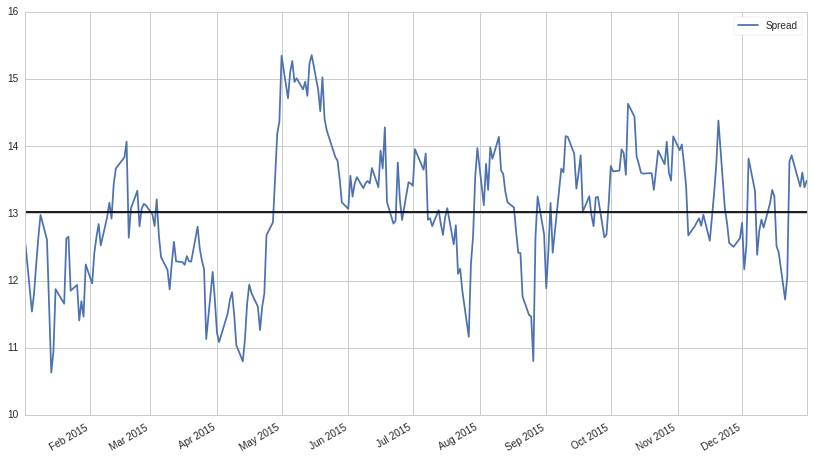


##b. Testing the Coefficient

Use your coefficient from part a to plot the weighted spread using prices from the first half of 2016, and check whether the result is still stationary.


In [0]:
S1_out = get_pricing('MTRN', fields=['price'], 
                        start_date='2016-01-01', end_date='2016-07-01')['price']
S2_out = get_pricing('SCCO', fields=['price'], 
                        start_date='2016-01-01', end_date='2016-07-01')['price']

In [0]:
spread = S2_out - b * S1_out
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

print "p-value for spread stationarity: ", adfuller(spread)[1]
# Our p-value is greater than 0.05 so we conclude that this calculation of
# the spread is non-stationary out of sample



```
p-value for spread stationarity:  0.145567411661
```



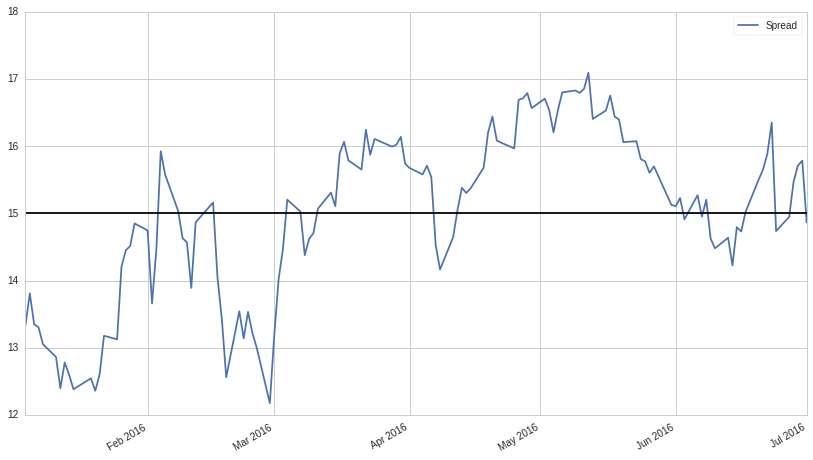